In [28]:
%pylab nbagg
from tvb.simulator.lab import *
import os.path
from matplotlib import colors, cm
import time
import scipy.signal as sig

import numpy as np
import pandas as pd
import scipy.io

# downloaded library for peak detection in z time series
import peakdetect
from runmainsim import *
import visualize

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
patients = ['id001_ac', 'id002_cj', 'id014_rb']
patients = ['id001_ac']
for patient in patients:
#     patient='cj'
    # 1000 = 1 second
    samplerate = 1000 # Hz
    sim_length = 30*samplerate

    ezregion = ['ctx-lh-bankssts']
    pzregion = ['ctx-lh-cuneus']
#     pzregion = []

    outputdir = os.path.join('/Users/adam2392/Documents/pydata/tvb_forwardsim/', patient)
    if not os.path.exists(outputdir):
        os.mkdir(outputdir)
    filename = os.path.join(outputdir, patient+'_sim_nez'+str(len(ezregion))+\
                                        '_npz'+str(len(pzregion))+'.npz')

    period = 1
    # x0c value = -2.05
    x0norm=-2.5
    x0ez=-1.6
    x0pz=-2.04
    
    # intialized hard coded parameters
    epileptor_r = 0.0002       # Temporal scaling in the third state variable
    epiks = -0.5                 # Permittivity coupling, fast to slow time scale
    epitt = 0.05               # time scale of simulation
    epitau = 10                # Temporal scaling coefficient in fifth st var

    # depends on epileptor variables of interest: it is where the x2-y2 var is
    varindex = [1]
    
    # parameters for heun-stochastic integrator
    heun_ts = 0.05
    noise_cov = np.array([0.001, 0.001, 0.,\
                    0.0001, 0.0001, 0.])
    
    root_dir = os.getcwd()
    project_dir = os.path.join(root_dir, "metadata/"+patient)
    print "Project directory for meta data is : ", project_dir
    print "File to be saved is: ", filename

    ####### Initialize files needed to 
    # convert seeg.xyz to seeg.txt file
    sensorsfile = os.path.join(project_dir, "seeg.xyz")
    newsensorsfile = os.path.join(project_dir, "seeg.txt")
    try:
        os.rename(sensorsfile, newsensorsfile)
    except:
        print "Already renamed seeg.xyz possibly!"

    # convert gain_inv-square.mat file into gain_inv-square.txt file
    gainmatfile = os.path.join(project_dir, "gain_inv-square.mat")
    newgainmatfile = os.path.join(project_dir, "gain_inv-square.txt")
    try:
        os.rename(gainmatfile, newgainmatfile)
    except:
        print "Already renamed gain_inv-square.mat possibly!"
    gainmatfile = newgainmatfile
    sensorsfile = newsensorsfile
    
    
    confile = os.path.join(project_dir, "connectivity.zip")
    ####################### 1. Structural Connectivity ########################
    con = initconn(confile)
    # determine what the regions are for this certain parcellation
    # and get the ez indices, pz indices desired
    regions = con.region_labels
    ezindices, pzindices = getindexofregion(regions, ezregion, pzregion)
    num_regions = len(regions)
    
    ####################### 2. Neural Mass Model @ Nodes ######################
    epileptors = initepileptor(epileptor_r, epiks, epitt, epitau, x0norm, \
                              x0ez, x0pz, ezindices, pzindices, num_regions)    
    ####################### 3. Integrator for Models ##########################
    heunint = initintegrator(heun_ts, noise_cov)
    ################## 4. Difference Coupling Between Nodes ###################
    coupl = initcoupling(a=1.)
    ############## 5. Import Sensor XYZ, Gain Matrix For Monitors #############
    monitors = initmonitors(period, sensorsfile, gainmatfile, varindex)
    
    
    seeg_xyz = tvbsim.util.extractseegxyz(sensorsfile)
    region_centers = con.centres
    seeg_index, distance = tvbsim.util.findclosestcontact(ezindices, region_centers, seeg_xyz)
    seeg_contact = seeg_xyz.iloc[seeg_index].index[0]
    print str(seeg_contact)
    
    # get the modified seeg xyz and gain matrix
    modseeg = tvbsim.util.movecontact(seeg_xyz, region_centers, ezindices, seeg_contact)
    modgain = tvbsim.util.simplest_gain_matrix(modseeg.as_matrix(), region_centers)
    
    # modify the config of the monitors
    monitors[1].sensors.locations = modseeg
    monitors[1].gain = modgain
    
    # get initial conditions and then setup entire simulation configuration
    initcond = initconditions(x0norm, num_regions)
    sim, configs = setupconfig(epileptors, con, coupl, heunint, monitors, initcond)
    
    times, epilepts, seegts = runsim(sim, sim_length)

    ######################## POST PROCESSING #################################
    # post process by cutting off first 5 seconds of simulation
    # for now, don't, since intiial conditions
    times, epits, seegts, zts = postprocts(epilepts, seegts, times)
    
    # get the onset, offset times
    onsettimes = None
    offsettimes = None
    try:
        onsettimes, offsettimes = findonsetoffset(zts[ezindices, :].squeeze())
    except:
        print "Still not working..."

    ######################## SAVING ALL DATA #################################
    regions = configs.connectivity.region_labels
    # Save files
    meta = {
        'x0ez':x0ez,
        'x0pz':x0pz,
        'x0norm':x0norm,
        'regions': regions,
        'regions_centers': configs.connectivity.centres,
        'seeg_contacts': configs.monitors[1].sensors.labels,
        'seeg_xyz': configs.monitors[1].sensors.locations,
        'ez': regions[ezindices],
        'pz': regions[pzindices],
        'ezindices': ezindices,
        'pzindices': pzindices,
        'onsettimes':onsettimes,
        'offsettimes':offsettimes,
        'patient':patient,
    }

    # save tseries
    np.savez(filename, epits=epits, seegts=seegts, \
             times=times, zts=zts, metadata=meta)
    break

Project directory for meta data is :  /Users/adam2392/Documents/tvb/metadata/id001_ac
File to be saved is:  /Users/adam2392/Documents/pydata/tvb_forwardsim/id001_ac/id001_ac_sim_nez1_npz1.npz
Already renamed seeg.xyz possibly!
Already renamed gain_inv-square.mat possibly!
OR'1
is left


In [41]:
patient = 'id014_rb'
patient = 'id001_ac'
eznum=1
pznum=1

outputdir = os.path.join('/Users/adam2392/Documents/pydata/tvb_forwardsim/', patient)
if not os.path.exists(outputdir):
    os.mkdir(outputdir)
filename = os.path.join(outputdir, patient+'_sim_nez'+str(eznum)+\
                                '_npz'+str(pznum)+'.npz')

data = np.load(filename)

# extract data and metadata from simulation
epits = data['epits']
zts = data['zts']
times = data['times']
seegts = data['seegts']

metadata = data['metadata'].item()

print filename
# print findonsetoffset(zts[ezindices,:])
print data.keys()
print "Meta data contains: ", metadata.keys()
print metadata['pzindices']

/Users/adam2392/Documents/pydata/tvb_forwardsim/id001_ac/id001_ac_sim_nez1_npz1.npz
['metadata', 'zts', 'seegts', 'epits', 'times']
Meta data contains:  ['patient', 'pz', 'onsettimes', 'seeg_xyz', 'x0ez', 'regions_centers', 'regions', 'seeg_contacts', 'offsettimes', 'x0pz', 'ez', 'pzindices', 'x0norm', 'ezindices']
[3]


ezreion is:  ['ctx-lh-bankssts']
pzregion is:  ['ctx-lh-cuneus']
x0 values are (ez, pz, norm):  -1.6 -2.04 -2.5
time series shape is:  (84, 30000)


<IPython.core.display.Javascript object>


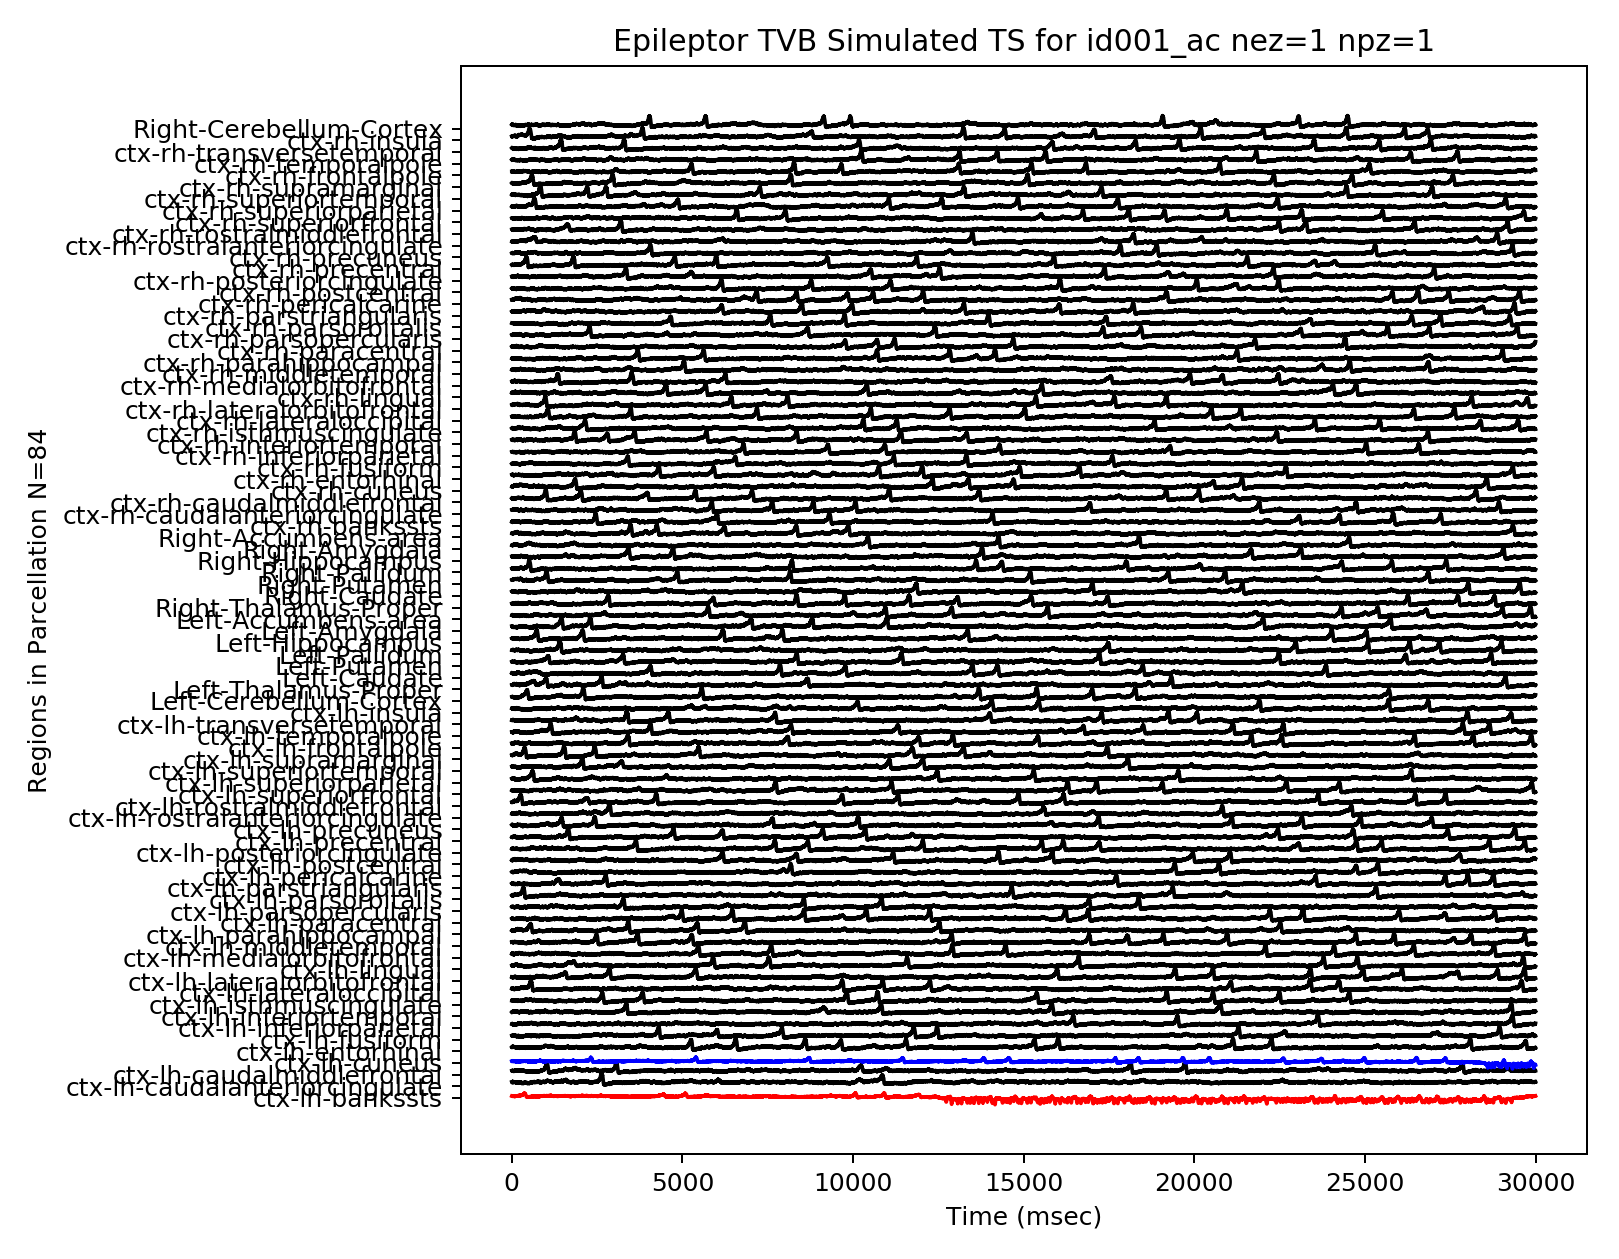

ezreion is:  ['ctx-lh-bankssts']
pzregion is:  ['ctx-lh-cuneus']
x0 values are (ez, pz, norm):  -1.6 -2.04 -2.5
time series shape is:  (84, 30000)


<IPython.core.display.Javascript object>


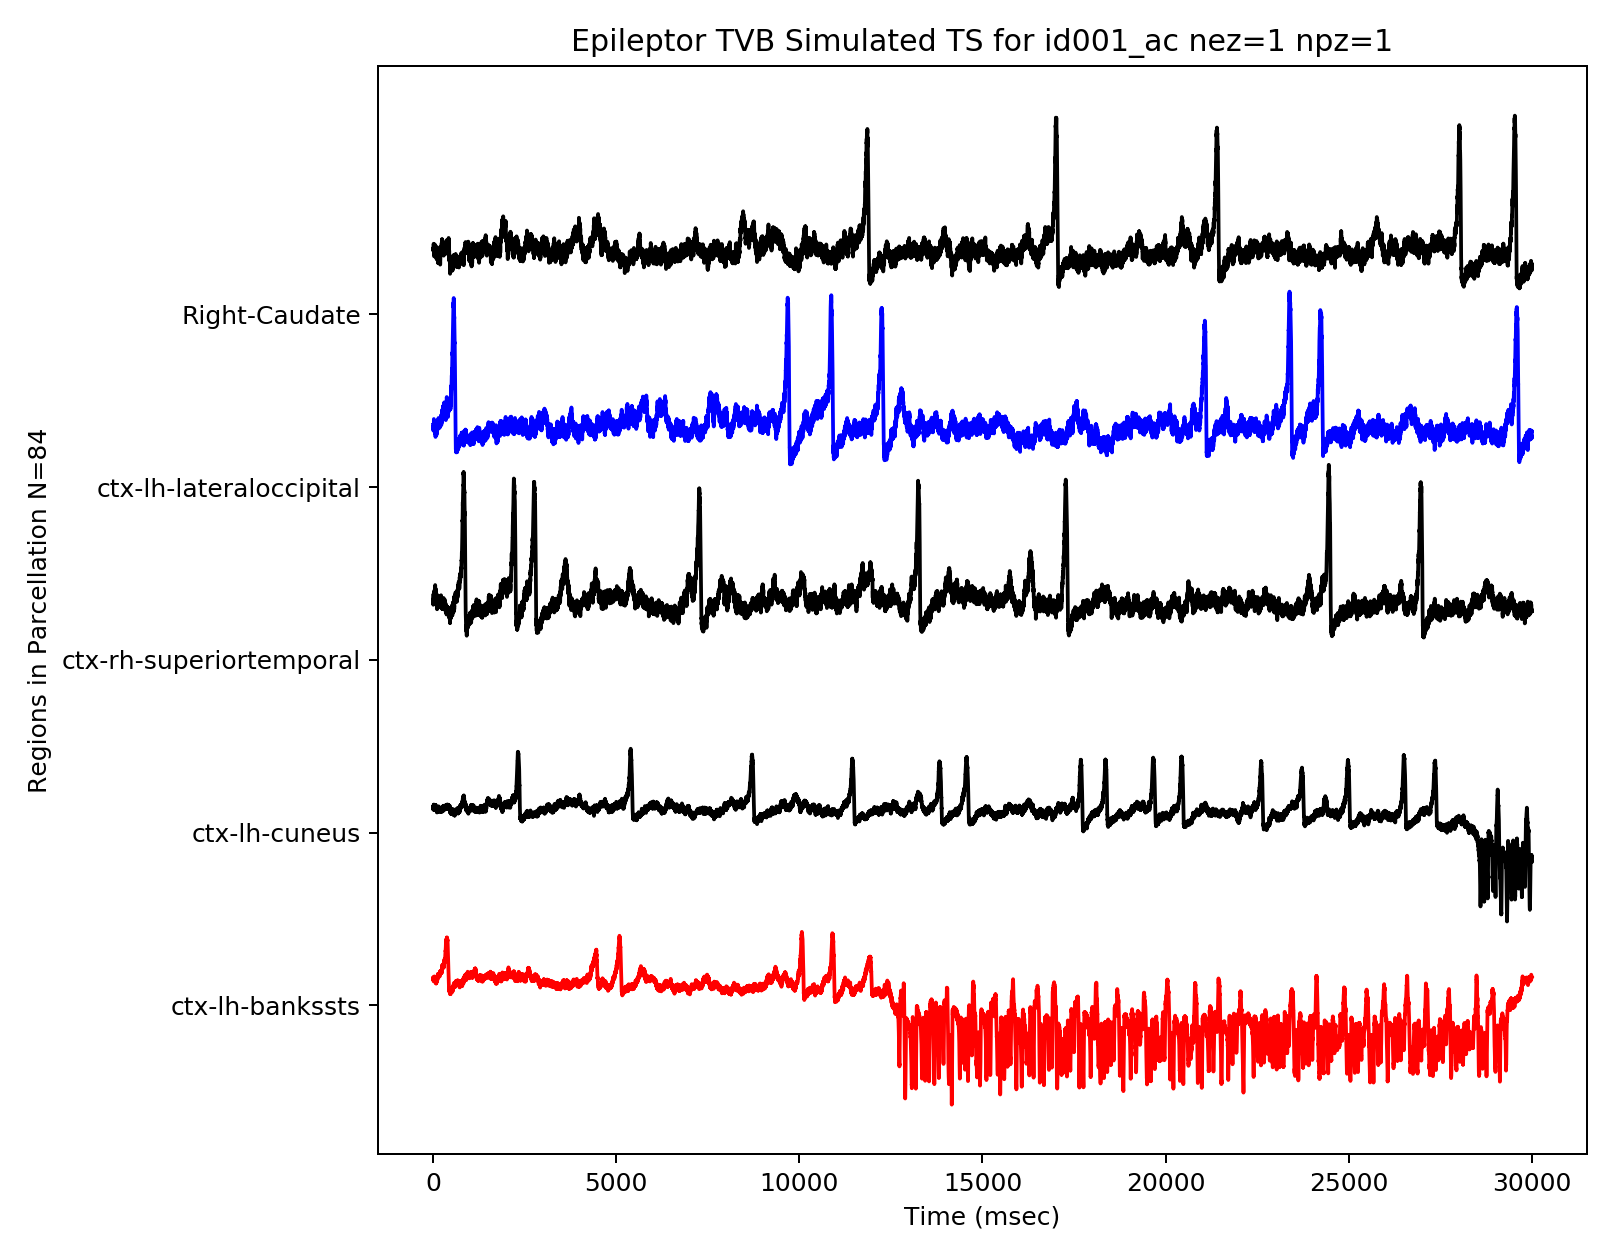

In [42]:
# get shapes of epits
numregions, numsamps = epits.shape
numchans, numsamps = seegts.shape

timewindowbegin = 0
timewindowend = numsamps

############################### PLOTTING OF EPILEPTOR TS ###############################
epifig = visualize.plotepileptorts(epits, times, metadata, patient, plotsubset=False)
epifigsubset = visualize.plotepileptorts(epits, times, metadata, patient, plotsubset=True)

['patient', 'pz', 'onsettimes', 'seeg_xyz', 'x0ez', 'regions_centers', 'regions', 'seeg_contacts', 'offsettimes', 'x0pz', 'ez', 'pzindices', 'x0norm', 'ezindices']
(30000,)
id001_ac
(70, 30000)
ezreion is:  ['ctx-lh-bankssts']
pzregion is:  ['ctx-lh-cuneus']
x0 values are (ez, pz, norm):  -1.6 -2.04 -2.5
time series shape is:  (70, 30000)


<IPython.core.display.Javascript object>


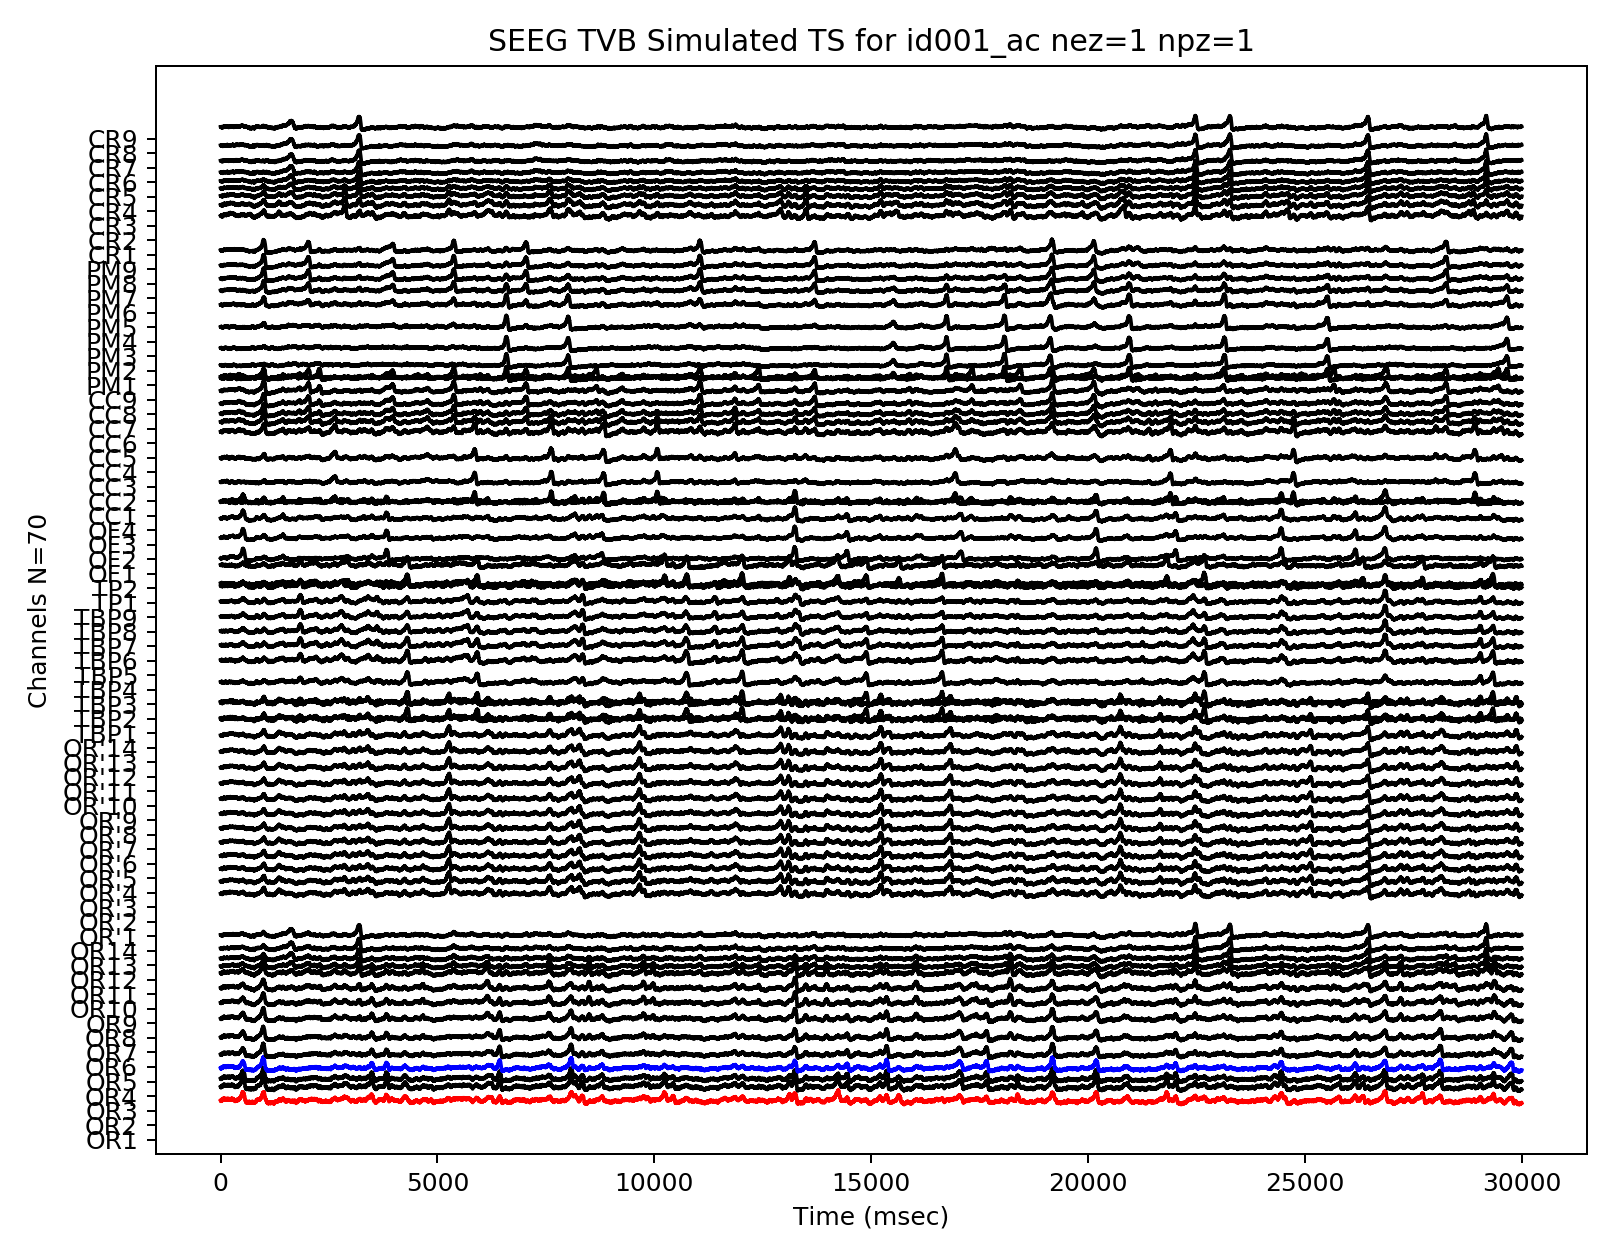

Figure(900x700)
(array([43]), array([ 87.65750907]))


In [43]:
print metadata.keys()
print times.shape
print patient
print seegts.shape
############################### PLOTTING OF SEEG TS ###############################
seegfig = visualize.plotseegts(seegts, times, metadata, patient, plotsubset=False)
print seegfig

# get the distance to closest electrode
near_seeg = tvbsim.util.findclosestcontact(metadata['ezindices'], metadata['regions_centers'], metadata['seeg_xyz'])
print near_seeg